In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# load the data from URL
kiwo_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv'
umsatz_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv'
wetter_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv'

df_kiwo = pd.read_csv(kiwo_url)
df_umsatz = pd.read_csv(umsatz_url)
df_wetter = pd.read_csv(wetter_url)

In [3]:
# Merge df_umsatz with df_wetter on the 'date' column
df = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')

# Merge the result with df_kiwo on the 'date' column
df = pd.merge(df, df_kiwo, on='Datum', how='left')

/tmp/ipykernel_30281/102933549.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Bewoelkung'].fillna(df['Bewoelkung'].median(), inplace=True)
/tmp/ipykernel_30281/102933549.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

Mean Squared Error: 4257.01548244793
R^2 Score: 0.7570681654719407
                Feature  Coefficient
7         Warengruppe_2   283.090448
10        Warengruppe_5   156.723094
8         Warengruppe_3    40.603835
31      Wettercode_75.0    31.407062
1            Temperatur    29.813366
29      Wettercode_71.0    21.399104
6             IsWeekend    20.658840
19      Wettercode_22.0    20.178811
20      Wettercode_28.0    19.941715
34      Wettercode_95.0    18.398788
27      Wettercode_68.0    17.143772
32      Wettercode_77.0    13.857921
13       Wettercode_3.0    11.468045
22      Wettercode_49.0     6.728893
14       Wettercode_5.0     6.536164
37       Weekday_Sunday     6.508222
15      Wettercode_10.0     4.361346
5                   Day     3.824020
18      Wettercode_21.0     3.299495
17      Wettercode_20.0     2.872762
36     Weekday_Saturday     2.843507
26      Wettercode_65.0     2.751446
24      Wettercode_61.0     1.959965
2   Windgeschwindigkeit     1.230443
30      

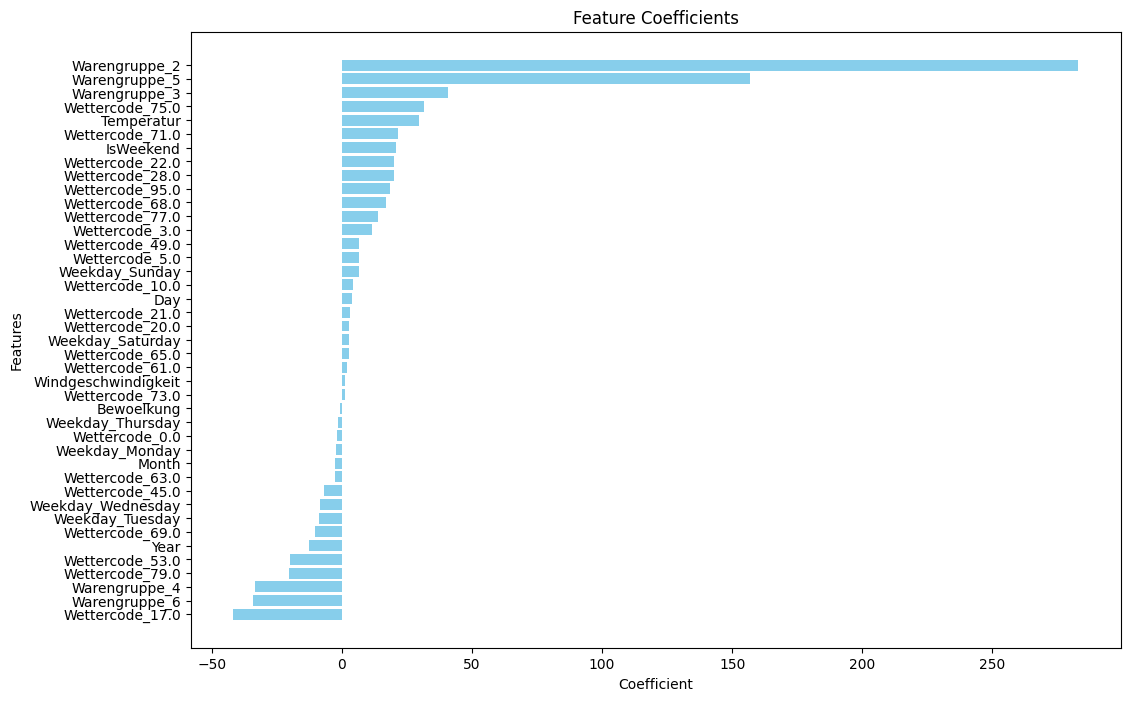

In [ ]:
# Convert Datum to datetime
df['Datum'] = pd.to_datetime(df['Datum'])

# Extract date features
df['Year'] = df['Datum'].dt.year
df['Month'] = df['Datum'].dt.month
df['Day'] = df['Datum'].dt.day
df['Weekday'] = df['Datum'].dt.day_name()
df['IsWeekend'] = df['Weekday'].isin(['Saturday', 'Sunday']).astype(int)

# Fill missing values
# Numerical columns
df['Bewoelkung'].fillna(df['Bewoelkung'].median(), inplace=True)
df['Temperatur'].fillna(df['Temperatur'].median(), inplace=True)
df['Windgeschwindigkeit'].fillna(df['Windgeschwindigkeit'].median(), inplace=True)
df['Wettercode'].fillna(-1, inplace=True)  # Use -1 for missing categorical values

# Categorical column KielerWoche (binary indicator for festival days)
df['KielerWoche'] = df['KielerWoche'].fillna(0).astype(int)

# Drop unused columns
df.drop(columns=['Datum'], inplace=True)

# Separate target variable (Umsatz) and features
X = df.drop(columns=['Umsatz'])
y = df['Umsatz']

# Identify categorical and numerical columns
categorical_columns = ['Warengruppe', 'Wettercode', 'Weekday']
numerical_columns = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Year', 'Month', 'Day', 'IsWeekend']

# One-hot encode categorical variables, standardize numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

# Define pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Extract feature coefficients from the Linear Regression model
model = pipeline.named_steps['model']
feature_names = numerical_columns + list(pipeline.named_steps['preprocessor'].
                                         transformers_[1][1].get_feature_names_out(categorical_columns))
coefficients = model.coef_
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort and display feature coefficients
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print(coeff_df)

# Optional: Visualize feature coefficients
plt.figure(figsize=(12, 8))
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Feature Coefficients')
plt.gca().invert_yaxis()
plt.show()


🚨 **We need to bin temperature and add more variables (e.g. Wochentag, Feiertage, Cruiseships?, Events, Umsatz vom Vortag, etc.)**

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    explained_variance_score, 
    r2_score,
    mean_absolute_percentage_error
)
from sklearn.preprocessing import StandardScaler

# Prepare data
X = df[['Temperatur', 'Windgeschwindigkeit']]
y = df['Umsatz']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Advanced Metrics
metrics = {
    'Mean Squared Error': mean_squared_error(y_test, y_pred),
    'Root Mean Squared Error': np.sqrt(mean_squared_error(y_test, y_pred)),
    'Mean Absolute Error': mean_absolute_error(y_test, y_pred),
    'R-squared': r2_score(y_test, y_pred),
    'Explained Variance Score': explained_variance_score(y_test, y_pred)
}

# Cross-validation scores
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

# Print results
for metric, value in metrics.items():
    print(f"{metric}: {value}")

print("\nCross-Validation R2 Scores:", cv_scores)
print("Mean CV R2 Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print("\nFeature Importance:")
print(feature_importance)


# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")


Mean Squared Error: 16639.628813700616
Root Mean Squared Error: 128.99468521493674
Mean Absolute Error: 104.10010134645283
R-squared: 0.05043907633293654
Explained Variance Score: 0.05611113533060719

Cross-Validation R2 Scores: [0.05320298 0.05228128 0.03489896 0.05398599 0.04463567]
Mean CV R2 Score: 0.047800975291543854
Standard Deviation of CV Scores: 0.0072662274170241774

Feature Importance:
               Feature  Coefficient
0           Temperatur    32.502506
1  Windgeschwindigkeit     1.666148
Mean Absolute Percentage Error (MAPE): 82.72%
